In [2]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import flow.visualize.visualize_ring as visualize_ring

import torch

# Anti-Flow specific functions for  detection:
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

from detector_dev.utils import run_ring_sim_variable_cfm,Bando_OVM_FTL

from Adversaries.controllers.car_following_adversarial import ACC_Benign

import detector_dev.utils as utils

import Data_Processing.sim_processing_utils as sim_processing_utils

from Data_Processing.sim_processing_utils import get_trajectory_timeseries

from importlib import reload

print('Libraries loaded.')

1.7.1
Libraries loaded.


In [12]:
import misc
reload(misc)
from misc import sim_attacker_follows_smoother,sim_attacker_precedes_smoother,sim_only_HVs

# Perform simulation with only human drivers:

In [13]:
trajectory_dict_all_human,emission_path_HVs = sim_only_HVs()

Number of classes of driver: 40
Running ring simulation, ring length: 500


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 963.6793141664181
data/ring_variable_cfm_20230111-1149071673459347.9950888-0_emission.csv data
Average, std velocities: 5.606237440440143, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 963.6793141664181, 0.0
Total time: 18.536788940429688
steps/second: 122.5547456287077
Data loaded, total time: 1.1963131427764893


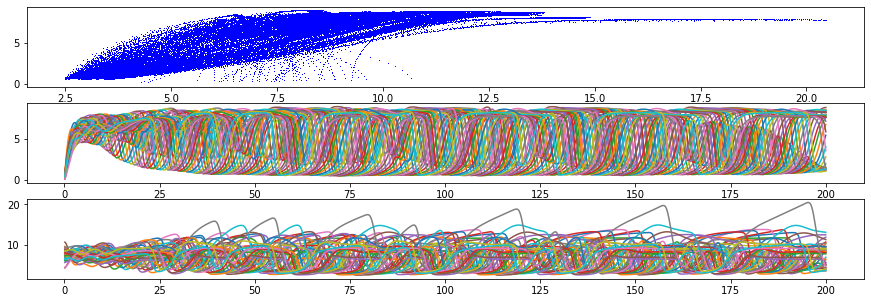

In [17]:
begin_time = 0.0
end_time = 500.0

veh_ids = (trajectory_dict_all_human.keys())
plt.figure(figsize=[15,5])

plt.subplot(3,1,1)

for veh_id in veh_ids:
    time = trajectory_dict_all_human[veh_id][:,0]
    index_select = np.logical_and(time>begin_time,time<end_time)
    
    time = time[index_select]
    
    speed = trajectory_dict_all_human[veh_id][:,1]
    spacing = trajectory_dict_all_human[veh_id][:,2]
    
    speed = speed[index_select]
    spacing = spacing[index_select]
    
    plt.subplot(3,1,1)
    plt.plot(spacing,speed,'b,')
    
    plt.subplot(3,1,2)
    plt.plot(time,speed)
    
    plt.subplot(3,1,3)
    plt.plot(time,spacing)

# Train a detector:

In [23]:
import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X

import torch

# Anti-Flow specific functions for  detection:

from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

print('Imported detection libraries.')

Imported detection libraries.


In [49]:
def make_timeseries_list(trajectory_dict):
    timeseries_list = []
    for veh_id in trajectory_dict:
        trajectory_samples = []
        trajectory_data = trajectory_dict[veh_id]
        
        speed = trajectory_data[:,1]
        accel = np.gradient(speed,.1)
        head_way = trajectory_data[:,2]
        rel_vel = trajectory_data[:,3]
        
        trajectory_samples.append(speed)
        trajectory_samples.append(accel)
        trajectory_samples.append(head_way)
        trajectory_samples.append(rel_vel)
        
        timeseries_list.append(trajectory_samples)
    return timeseries_list

model = get_cnn_lstm_ae_model(n_features=4)
model_file_name = 'All_HV_detector'
timeseries_list = []
for veh_id in trajectory_dict_all_human:
    trajectory_samples = []
    for i in range(4):
        trajectory_samples.append(trajectory_dict_all_human[veh_id][:,i])
    timeseries_list.append(trajectory_samples)

train_X = make_train_X(timeseries_list)

print('Training data prepared.')

Training data prepared.


In [52]:
model = train_model(model,train_X,model_file_name)

Loaded existing model: /Users/vanderbilt/Desktop/Research_2022/Anti-Flow/detector_dev/test_smoothers/models/cnn_lstm_ae_All_HV_detector.pt
Best loss 52.94353012084961
Beginning training.
Number epochs: 0 epoch step time: 1.5420310497283936
Epoch 0, total loss 27735.235107, total predictions 400, avg loss 69.338088 2023-01-12 10:58:49.167964
Number epochs: 1 epoch step time: 1.477114200592041
Number epochs: 2 epoch step time: 1.4886348247528076
Number epochs: 3 epoch step time: 1.46983003616333
Number epochs: 4 epoch step time: 1.477851152420044
Saving model. Best loss: 50.9209555053711
Number epochs: 5 epoch step time: 1.4659919738769531
Epoch 5, total loss 40644.401245, total predictions 400, avg loss 101.611003 2023-01-12 10:58:56.548145
Number epochs: 6 epoch step time: 1.4475903511047363
Number epochs: 7 epoch step time: 1.453705072402954
Saving model. Best loss: 49.92546951293945
Number epochs: 8 epoch step time: 1.4574131965637207
Saving model. Best loss: 49.08996429443359
Number

Number epochs: 94 epoch step time: 1.602978229522705
Saving model. Best loss: 40.83226303100586
Number epochs: 95 epoch step time: 2.2618532180786133
Epoch 95, total loss 16323.869476, total predictions 400, avg loss 40.809674 2023-01-12 11:01:18.152980
Saving model. Best loss: 40.8096736907959
Number epochs: 96 epoch step time: 1.6713037490844727
Saving model. Best loss: 40.732573928833006
Number epochs: 97 epoch step time: 1.5577449798583984
Saving model. Best loss: 40.70470695495605
Number epochs: 98 epoch step time: 1.5489161014556885
Number epochs: 99 epoch step time: 1.8029189109802246
Number epochs: 100 epoch step time: 1.8226358890533447
Epoch 100, total loss 16906.305389, total predictions 400, avg loss 42.265763 2023-01-12 11:01:26.558355
Number epochs: 101 epoch step time: 4.193653106689453
Number epochs: 102 epoch step time: 3.4115142822265625
Number epochs: 103 epoch step time: 2.140458822250366
Number epochs: 104 epoch step time: 1.956118106842041
Number epochs: 105 epoch

In [79]:
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window_mult_feat

import sys

reload(misc)

from misc import get_losses_per_vehicle

In [53]:
time = np.arange(0.1,200.1,0.1)
losses_dict = get_losses_per_vehicle(trajectory_dict_all_human,time,model)

Vehicles processed: 40



Text(0.5, 0, 'Time [s]')

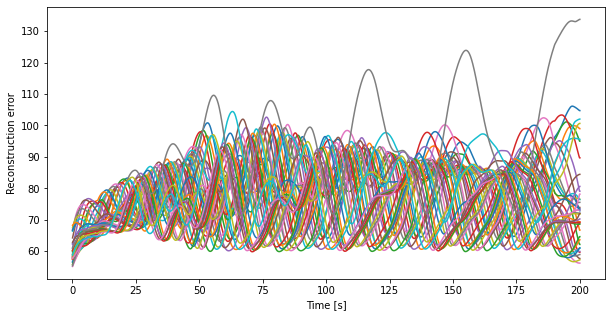

In [77]:
plt.figure(figsize=[10,5])

for veh_id in losses_dict:
    loss = losses_dict[veh_id]
    plt.plot(time,loss)
    
    if('bando' not in veh_id): print(veh_id)
plt.ylabel('Reconstruction error')
plt.xlabel('Time [s]')

# Perform simulation with an attacker following a smoother:

In [7]:
v_des = 7.0
trajectory_dict_attacker_follows_smoother = sim_attacker_follows_smoother(v_des)
print('Simulation finished.')

Number of classes of driver: 3
Running ring simulation, ring length: 500
Will engage in multiple attacks.


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 550.7972120142698
data/ring_variable_cfm_20230111-1117511673457471.6230552-0_emission.csv data
Average, std velocities: 6.012520627975192, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 550.7972120142698, 0.0
Total time: 20.10078501701355
steps/second: 127.0102180431126
Data loaded, total time: 0.7349100112915039
Simulation finished.


# Test previously trained detection on new environment:

In [86]:
reload(misc)

from misc import get_losses_per_vehicle

losses_dict_smoother_follows_attacker = get_losses_per_vehicle(trajectory_dict_attacker_follows_smoother,time,model)

Vehicles processed: 40



Text(0.5, 1.0, 'Attacker follows smoother.')

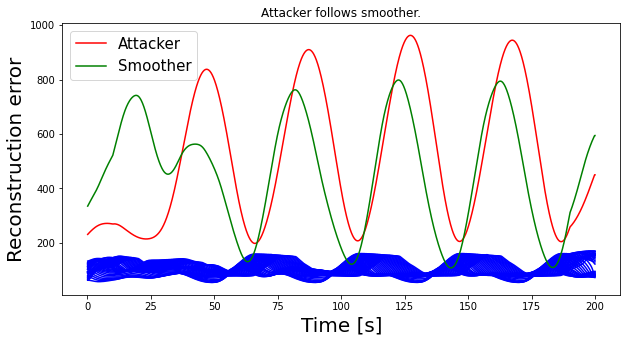

In [87]:
plt.figure(figsize=[10,5])

for veh_id in losses_dict_smoother_follows_attacker:
    loss = losses_dict_smoother_follows_attacker[veh_id]
    if('RDA' in veh_id):
        plt.plot(time,loss,'r',label='Attacker')
    elif('FollowerStopper' in veh_id):
        plt.plot(time,loss,'g',label='Smoother')
    else:
        plt.plot(time,loss,'b')
        
plt.ylabel('Reconstruction error',fontsize=20)
plt.xlabel('Time [s]',fontsize=20)
plt.legend(fontsize=15)
plt.title('Attacker follows smoother.')

# Perform simulation with attacker preceding a smoother:

In [64]:
v_des = 7.0
trajectory_dict_attacker_precedes_smoother = sim_attacker_precedes_smoother(v_des)
print('Simulation finished.')

Number of classes of driver: 3
Running ring simulation, ring length: 500
Will engage in multiple attacks.


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 855.5055295198481
data/ring_variable_cfm_20230112-1120251673544025.798902-0_emission.csv data
Average, std velocities: 6.070844684770409, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 855.5055295198481, 0.0
Total time: 17.60656189918518
steps/second: 136.62001173121712
Data loaded, total time: 0.6818768978118896
Simulation finished.


Text(0.5, 1.0, 'Attacker follows smoother.')

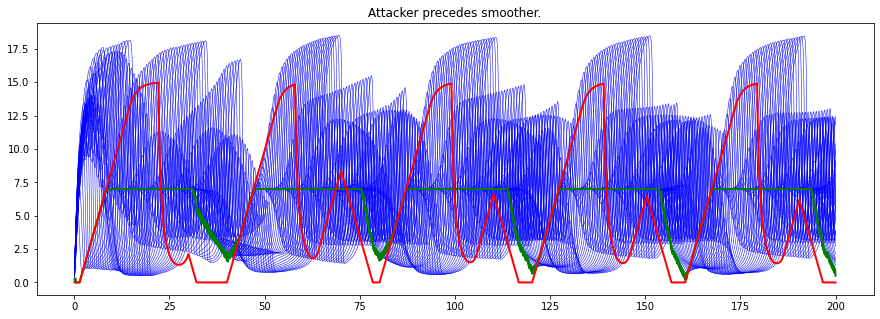

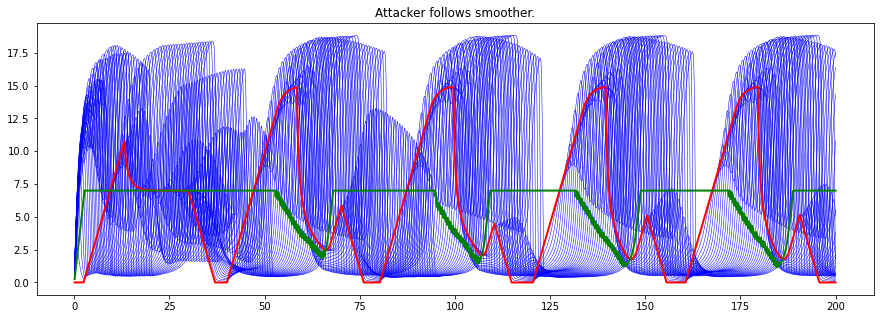

In [73]:
plt.figure(figsize=[15,5])
for veh_id in trajectory_dict_attacker_precedes_smoother:
    speed = trajectory_dict_attacker_precedes_smoother[veh_id][:,1]
    if('RDA' in veh_id):
        plt.plot(time,speed,'r',label='Attacker',linewidth=2.0)
    elif('FollowerStopper' in veh_id):
        plt.plot(time,speed,'g',label='Smoother',linewidth=2.0)
    else:
        plt.plot(time,speed,'b',linewidth=0.5)
plt.title('Attacker precedes smoother.')



plt.figure(figsize=[15,5])
for veh_id in trajectory_dict_attacker_follows_smoother:
    speed = trajectory_dict_attacker_follows_smoother[veh_id][:,1]
    if('RDA' in veh_id):
        plt.plot(time,speed,'r',label='Attacker',linewidth=2.0)
    elif('FollowerStopper' in veh_id):
        plt.plot(time,speed,'g',label='Smoother',linewidth=2.0)
    else:
        plt.plot(time,speed,'b',linewidth=0.5)
plt.title('Attacker follows smoother.')

# Calulate losses when attacker precedes follower

In [88]:
losses_dict_attacker_precedes_smoother = get_losses_per_vehicle(trajectory_dict_attacker_precedes_smoother,time,model)

Vehicles processed: 40



Text(0.5, 1.0, 'Attacker precedes smoother.')

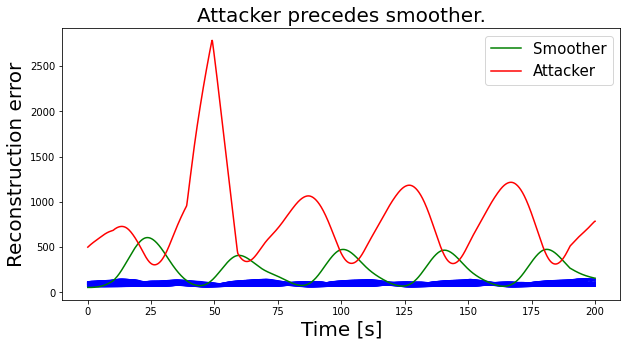

In [97]:
plt.figure(figsize=[10,5])

for veh_id in losses_dict_attacker_precedes_smoother:
    loss = losses_dict_attacker_precedes_smoother[veh_id]
    labeled_HV = False
    if('RDA' in veh_id):
        plt.plot(time,loss,'r',label='Attacker')
    elif('FollowerStopper' in veh_id):
        plt.plot(time,loss,'g',label='Smoother')
    else:
        if(not labeled_HV):
            plt.plot(time,loss,'b')
            labeled_HV = True
        else:
            plt.plot(time,loss,'b')
            
        
plt.ylabel('Reconstruction error',fontsize=20)
plt.xlabel('Time [s]',fontsize=20)
plt.legend(fontsize=15)
plt.title('Attacker precedes smoother.',fontsize=20)